In [1]:
!mkdir -p ~/aiffel/news_summarization/data
!ln -s ~/data/*.csv ~/aiffel/news_summarization/data

In [4]:
!ls -al /aiffel/data/Reviews.csv

-rwxr-xr-x 1 root root 300904694 Jun  7  2023 /aiffel/data/Reviews.csv


NLTK의 불용어(stopwords)

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

# https://stackoverflow.com/questions/33511544/how-to-get-rid-of-beautifulsoup-user-warning
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [4]:
data = data[["Summary", "Text"]]
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
data.sample(15)

,Summary,Text
40824,"Bad, Old, Products... Hartz sells these as Cru...",This product that I recieved was old... My dog...
19959,small for the price,"The product is good, the meat and cheese were ..."
89064,"Responsible, Sustainable, Convenient, and Deli...",I use them to make fillers for dumplings and r...
22746,worked,I used the product around my yard to try and p...
61567,Good for Indoor Smoking,"Great for making ""smoked"" ribs in your oven! ..."
47905,Love this stuff!!,This stuff is absolutely amazing! It tastes t...
32105,Yogi Detox...does its job..,I read reviews of this product but was not qui...
2204,Don't use this in place of regular molasses!,So I bought this pomegranate molasses to make ...
78902,Taste like Cholocate Milk,Sweetleaf Chocolate liquid Stevia is the best ...
48136,Zico coconut water is a terrific natural LAXATIVE,Zico was the sponsoring sports drink for SF Ma...


# Preprocess 1

1. duplicate
2. nan

In [10]:
print(data.shape)
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

(100000, 2)
Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [11]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [12]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Summary    1
Text       0
dtype: int64
전체 샘플수 : 88425


# Preprocess 2

3. text normalization
4. stopwords
5. 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거

### text normalization
> it'll은 it will과 같고, mustn't과 must not은 같은 표현

- 학습 전에 미리 같은 표현으로 통일
- normalization dict을 사용

In [13]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- Q. `remove_stopwords` ?
> Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것



In [15]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [17]:
# temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_summary))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  great way start day
summary: great way to start the day


### 모든 문장에 preprocess 적용

> 진행시간이 오래걸려 tqdm


1. 오래 걸리는 작업이라서 주석처리.

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [18]:
# apply(x), progress_apply(o)
data['Text'] = data['Text'].progress_apply(preprocess_sentence)
data['Summary'] = data['Summary'].progress_apply(lambda sentence: preprocess_sentence(sentence, remove_stopwords=False))

print(data[:5])

                 Summary                                               Text
0  good quality dog food  bought several vitality canned dog food produc...
1      not as advertised  product arrived labeled jumbo salted peanuts p...
2    delight says it all  confection around centuries light pillowy citr...
3         cough medicine  looking secret ingredient robitussin believe f...
4            great taffy  great taffy great price wide assortment yummy ...


#### 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있습니다.

In [21]:
data.replace('', np.nan, inplace=True)

In [22]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))
print(data.isnull().sum())

Summary    70
Text        0
dtype: int64
전체 샘플수 : 88355
Summary    0
Text       0
dtype: int64


#### 재사용을 고려해서, backup을 다운받도록 처리

In [5]:
# backup
# data.to_csv('./data_backup.csv', index=False)
data = pd.read_csv('./data_backup.csv')

In [6]:
data.sample(15)

,Summary,Text
30943,love this tea,drink tea winter long favorite hot teas best c...
7004,like the disposakups,like disposakups fixing one cup quicker use di...
88127,great flavours,daughter loves flavours love earth best excell...
79771,our dogs love it maybe too much,dogs love tasty dog food however dogs self reg...
84725,love metromint,water awesome place around sells super supplem...
148,awesome cornmeal,best cornmeal made regular cornbread hot water...
24786,ok product really sloooooww shipping,think strips bit sweet one grams protein price...
86544,pricing now way out of line no free shipping,bought item last month direct amazon pack line...
72563,refreshing,wonderful tea aroma world medium bodied tea br...
1424,fantastic coffee,husband fell love cafe britt coffee costa rica...


# Preprocess3
> 훈련 데이터와 테스트 데이터 나누기

1. 샘플의 최대 길이 정하기
2. 시작 토큰과 종료 토큰 추가하기 (sos / eos)

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


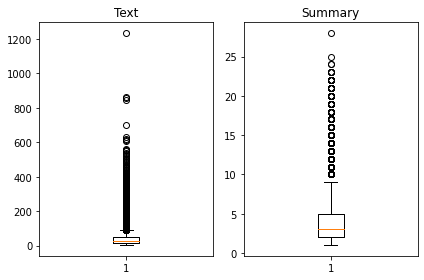

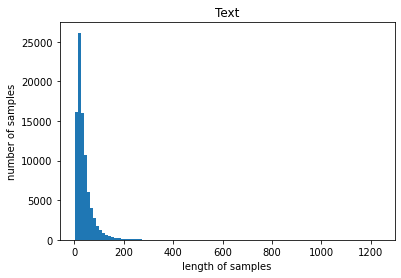

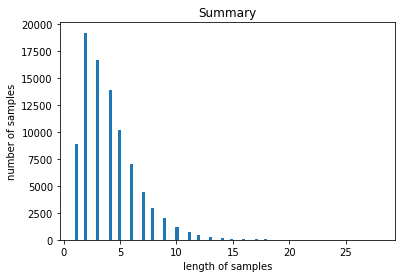

In [7]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


# 적절한 임의의 최대 길이
text_max_len = 50
summary_max_len = 8

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


- 각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다.

- **정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제**

In [9]:
before = len(data)

def is_within(text, max_len):
    return len(text.split()) <= max_len

filtered_text = data['Text'].apply(is_within, max_len=text_max_len)
filtered_summary = data['Summary'].apply(is_within, max_len=summary_max_len)

# merge
data = data[filtered_text & filtered_summary]
print('전체 샘플수 :', (len(data)))
print(f'삭제된 샘플수: {before - len(data)}')

전체 샘플수 : 65818
삭제된 샘플수: 22537


### sos, eos 추가

In [10]:
SOS = '<SOS>'
EOS = '<EOS>'

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : SOS + ' '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' ' + EOS)
data.head()

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,<SOS> good quality dog food,good quality dog food <EOS>
1,not as advertised,product arrived labeled jumbo salted peanuts p...,<SOS> not as advertised,not as advertised <EOS>
2,delight says it all,confection around centuries light pillowy citr...,<SOS> delight says it all,delight says it all <EOS>
3,cough medicine,looking secret ingredient robitussin believe f...,<SOS> cough medicine,cough medicine <EOS>
4,great taffy,great taffy great price wide assortment yummy ...,<SOS> great taffy,great taffy <EOS>


In [22]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

encoder_input.shape

(65818,)

In [23]:
# 1. shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 2. 20% index
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# 3. seperate
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[28228  4479 62282 ... 34959 10528 26514]
테스트 데이터의 수 : 13163
훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [24]:
encoder_input_train[10]

'like finer american chocolates piece day keeps dentis happy'

# Preprocess 4
> 정수 인코딩

1. 단어 집합(vocabulary) 만들기 및 정수 인코딩
2. 패딩하기


In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

#### 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32076
등장 빈도가 6번 이하인 희귀 단어의 수: 23804
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8272
단어 집합에서 희귀 단어의 비율: 74.21124828532236
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3819995576513335


In [27]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11, 270, 393, 3190, 204, 156, 2089, 77, 683, 371, 40, 3, 4408, 6798, 54, 1038, 1648, 156, 1160, 1528, 4669, 7197, 1648, 1804, 804, 5915, 3, 5, 85, 98, 289], [34, 306, 341, 292, 343, 28, 782, 306, 1237, 26, 447, 64, 85, 309, 6164, 22, 306, 341, 755, 83, 399, 50, 34, 306, 341, 49, 1030, 239, 519], [38, 24, 1447, 571, 4670, 405, 1, 205, 267, 236, 183, 1, 2463, 876, 888, 183, 6165, 96, 96, 59, 1308, 365, 1558, 217, 429, 1, 564, 90, 475, 153, 48, 181, 295]]


In [28]:
# Decoder tokenize (summary)
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [29]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10463
등장 빈도가 5번 이하인 희귀 단어의 수: 8082
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2381
단어 집합에서 희귀 단어의 비율: 77.24362037656503
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.87311016978338


In [30]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 634, 54, 137], [1, 24, 30, 653, 126], [1, 438, 23, 547], [1, 323], [1, 154, 66, 112, 71, 694, 30]]
target
decoder  [[634, 54, 137, 2], [24, 30, 653, 126, 2], [438, 23, 547, 2], [323, 2], [154, 66, 112, 71, 694, 30, 2]]


> 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성 존재

> 대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성 존재


- 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이므로 길이를 1로 해서 찾아야 합니다.

In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1236
삭제할 테스트 데이터의 개수 : 361
훈련 데이터의 개수 : 51419
훈련 레이블의 개수 : 51419
테스트 데이터의 개수 : 12802
테스트 레이블의 개수 : 12802


### Padding

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Model 설계

1. encoder
2. decoder

## Seq2Seq 모델 설계

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)


# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


> 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야합니다. 이 때문에 Dense의 인자로 `tar_vocab`인 2000을 주고, softmax층을 통과시킵니다. 

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Attention Model 설계

> 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 확인해보겠습니다. 

참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. [tf.keras.layers.AdditiveAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)


**아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층(디코더 lstm은 유지)을 수정합니다.**

In [37]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

> 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동합니다.

# Train

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 53s 152ms/step - loss: 2.7034 - val_loss: 2.4198
Epoch 2/50
201/201 [==============================] - 30s 151ms/step - loss: 2.3876 - val_loss: 2.2875
Epoch 3/50
201/201 [==============================] - 30s 149ms/step - loss: 2.2405 - val_loss: 2.1499
Epoch 4/50
201/201 [==============================] - 30s 149ms/step - loss: 2.1172 - val_loss: 2.0600
Epoch 5/50
201/201 [==============================] - 30s 150ms/step - loss: 2.0321 - val_loss: 2.0037
Epoch 6/50
201/201 [==============================] - 30s 149ms/step - loss: 1.9677 - val_loss: 1.9555
Epoch 7/50
201/201 [==============================] - 30s 149ms/step - loss: 1.9115 - val_loss: 1.9269
Epoch 8/50
201/201 [==============================] - 30s 150ms/step - loss: 1.8623 - val_loss: 1.9028
Epoch 9/50
201/201 [==============================] - 30s 150ms/step - loss: 1.8213 - val_loss: 1.8848
Epoch 10/50
201/201 [==============================] - 30s 149ms/step - l

#### Early Stopping을 사용할 경우 조심해야 하는 경우
> patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있습니다. 예를들어 patience가 3인 경우, 15 epoch에서 loss가 감소하다가 16 epoch부터 loss가 증가한다면 18 epoch 때 모델을 저장하고 학습을 종료합니다. 그래서 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.

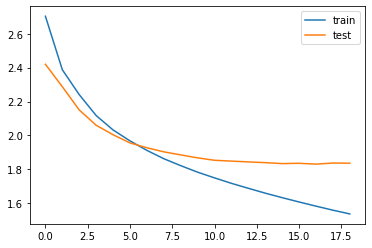

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Inference 모델 구현

> 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

**seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 합니다.**

- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [41]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index
# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word

In [46]:
src_index_to_word

{1: 'like',
 2: 'good',
 3: 'great',
 4: 'taste',
 5: 'product',
 6: 'love',
 7: 'one',
 8: 'coffee',
 9: 'flavor',
 10: 'would',
 11: 'tea',
 12: 'really',
 13: 'get',
 14: 'amazon',
 15: 'price',
 16: 'best',
 17: 'buy',
 18: 'much',
 19: 'food',
 20: 'time',
 21: 'little',
 22: 'use',
 23: 'find',
 24: 'tried',
 25: 'better',
 26: 'also',
 27: 'well',
 28: 'make',
 29: 'chocolate',
 30: 'try',
 31: 'eat',
 32: 'dog',
 33: 'even',
 34: 'bought',
 35: 'delicious',
 36: 'found',
 37: 'sweet',
 38: 'order',
 39: 'could',
 40: 'drink',
 41: 'tastes',
 42: 'recommend',
 43: 'bag',
 44: 'used',
 45: 'cup',
 46: 'loves',
 47: 'favorite',
 48: 'sugar',
 49: 'cannot',
 50: 'store',
 51: 'first',
 52: 'free',
 53: 'nice',
 54: 'made',
 55: 'way',
 56: 'box',
 57: 'go',
 58: 'perfect',
 59: 'got',
 60: 'mix',
 61: 'dogs',
 62: 'easy',
 63: 'day',
 64: 'since',
 65: 'think',
 66: 'snack',
 67: 'water',
 68: 'flavors',
 69: 'bit',
 70: 'ordered',
 71: 'many',
 72: 'hot',
 73: 'give',
 74: 'two',


In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    256000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!= 'eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


#### 정답 문장이 없는 추론(inference) 단계에서 모델 설계를 별도로 해주는 이유
생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문

# 모델 테스트

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    tmp = ''
    for s in input_seq:
        if s not in (0, tar_word_to_index['eos'], tar_word_to_index['sos']):
            tmp += tar_index_to_word[s] + ' '            
    return tmp

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : tastes good exactly fan granola like right dose cocoa makes tasty buy separately whole foods stores mix may mix made natural stuff worth buying one con powdery bottom exactly made big nuggets note saturated fat enjoy moderation buy reason give star price compared get powdery small grains package 
실제 요약 : good natural healthy snack nothing more nothing less 
예측 요약 :  delicious


원문 : giving two stars taste good first like reviewer said smell funny left bad taste mouth salty cooked seconds bag still stopped smelled burnt done nice idea think buy 
실제 요약 : thought it was good idea 
예측 요약 :  not that good


원문 : mixed vegetable cottage cheese curry one meals included kitchens india ready eat dinner variety pack ounce boxes much enjoyed dish found authentic tasting little spicy packet say contains servings closer family makes excellent main course side dish indian themed dinner makes enjoyable snack well highly recommended cfh 
실제 요약 : very good ready to eat meal highly recommended 
예측 

# 추출적 요약해보기
> 추상적 요약(seq2seq, transformer) 외에도 추출적 요약방법이 존재합니다.

추상적 요약처럼 새롭게 생성하는 방식이 아니라,  `textrank` 처럼 원문에서 중요한 문장들을 뽑아서 합치는 방식입니다.

- 원문의 단어들이 사용되기 때문에, 합치는 경우 문장이 매끄럽지 않은 단점

In [59]:
! pip list | grep summa

summa                         1.2.0


In [60]:
import requests
from summa.summarizer import summarize

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [61]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
